In [8]:
#from parse_kd import *
import re
import pandas as pd
import numpy as np
from chunk_utils import *
from sklearn.neighbors.kde import KernelDensity
import matplotlib
import scipy.cluster.hierarchy as hc
import matplotlib.pyplot as plt
from pyclustering.cluster.xmeans import xmeans
from scipy.special import kl_div
data_dir = './data/dw_freetext/'

In [2]:
%load_ext autoreload
%autoreload 2
matplotlib.rcParams['figure.figsize'] = 8,5

In [3]:
df = pd.read_csv(data_dir+'GunControl_400.csv', delimiter='\t', usecols=[0,6,10])
df_filtered = df[df['Task']=='Copy_2']
# "Copy_2" column = when they're stating true opinion, repeating (transcribing) the essay already written
df_filtered.head(7)

,UserName,Task,ReviewMeta
1,A10E8QHPV30BAD,Copy_2,0 MouseUp 0 0;874 KeyDown 16;946 KeyDown 73;10...
5,A11T1LGIWPM9Z1,Copy_2,0 MouseUp 0 0;784 KeyDown 16;863 KeyDown 84;92...
9,A145PJ769UGAID,Copy_2,0 MouseUp 0 0;1517 KeyDown 16;1517 KeyDown 87;...
13,A161NZP385W1TX,Copy_2,0 MouseUp 0 0;1621 KeyDown 16;1734 KeyDown 84;...
17,A168RQT8B18FH,Copy_2,0 MouseUp 0 0;2112 KeyDown 16;2311 KeyDown 73;...
21,A16HFBY06FP1RJ,Copy_2,0 MouseUp 0 0;317 KeyDown 16;543 KeyDown 71;62...
25,A191P01GHJRPWO,Copy_2,0 MouseUp 0 0;7007 KeyDown 16;7018 KeyDown 73;...


In [4]:
phrase = "government"

phrase_delays = []

for textIndex in range(df_filtered.shape[0]):
#for textIndex in range(100,120):    
    rawkd = df_filtered['ReviewMeta'].iloc[textIndex]
    phrase_keys = get_phrases_from_rawkd(rawkd, phrase)    
    this_delays = [keypress2delays(phrase, k) for k in phrase_keys]
    
    phrase_delays.extend(this_delays)
    
    
phrase_delays = np.array(phrase_delays)
print ("{} : {}".format(phrase, len(phrase_delays)))

government : 145


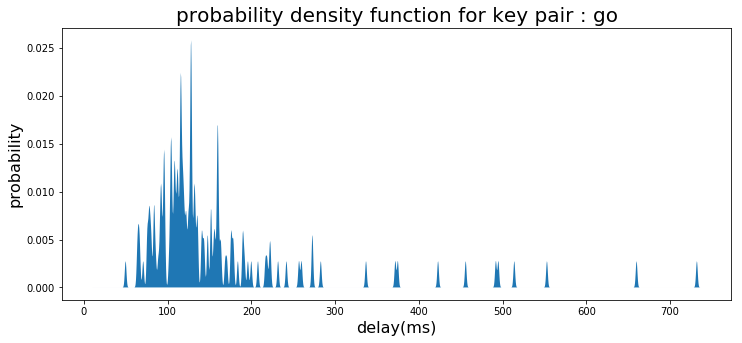

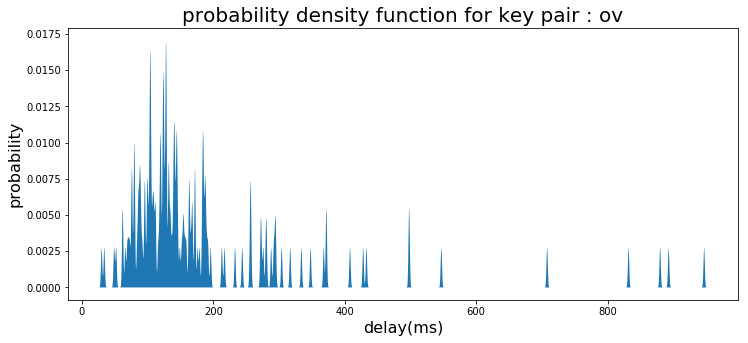

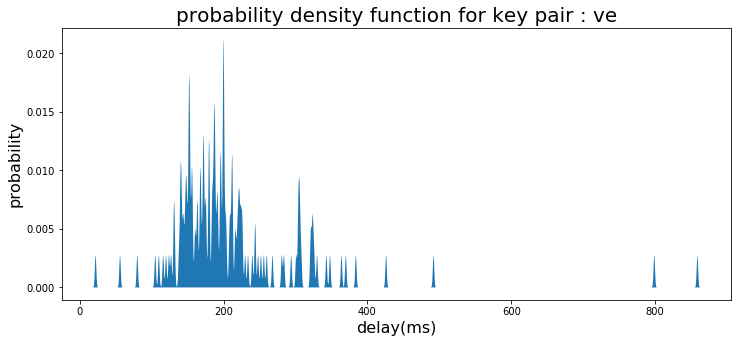

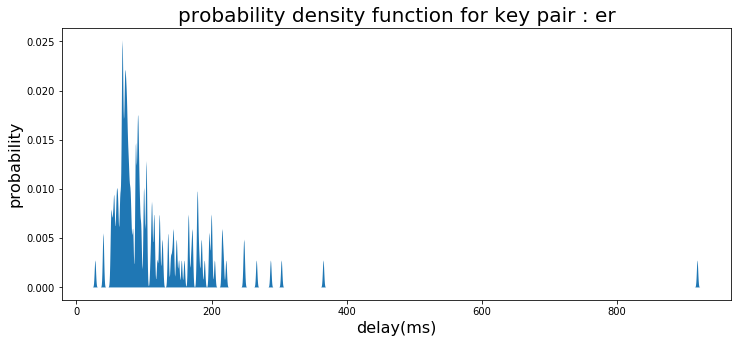

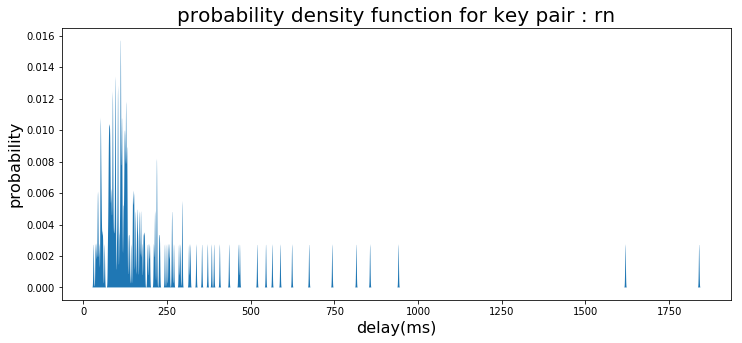

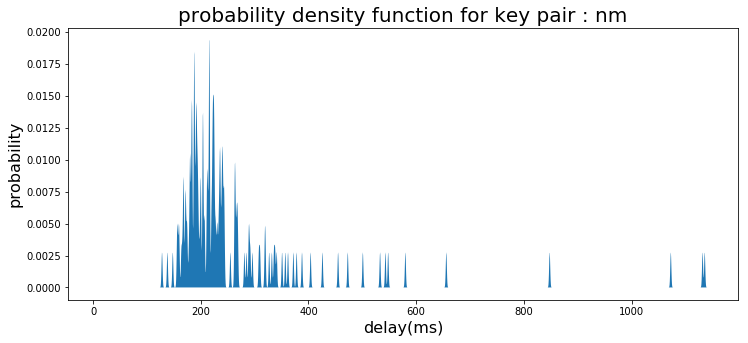

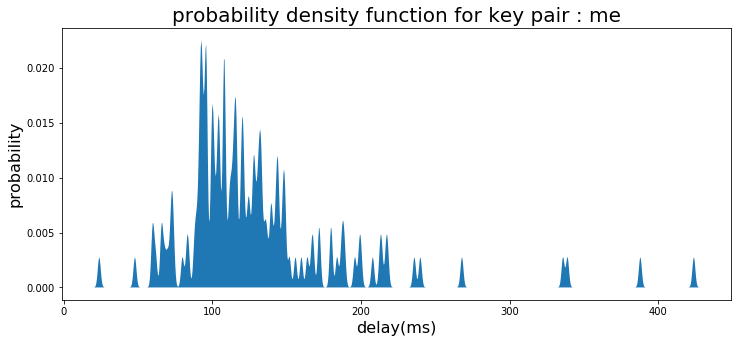

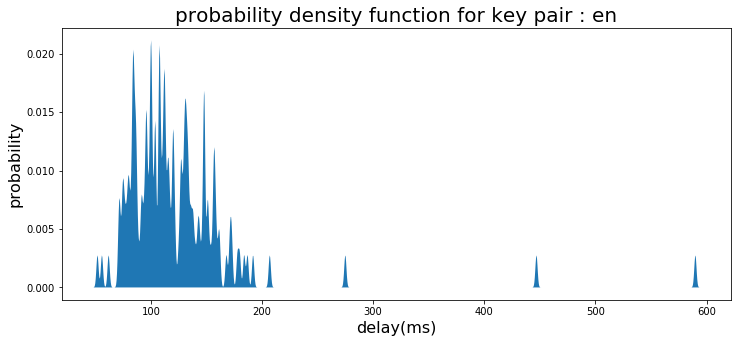

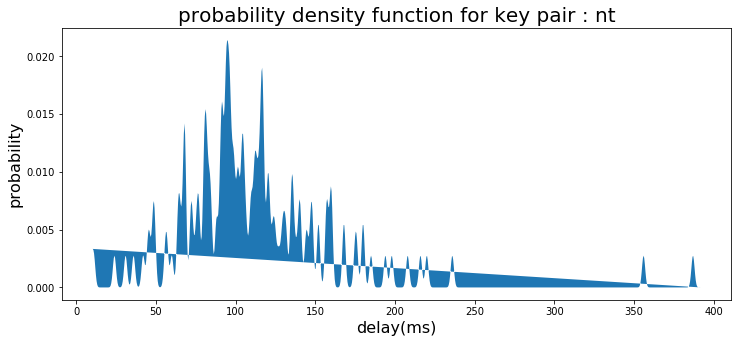

In [9]:
models = [KernelDensity() for  x in range(phrase_delays.shape[1])]
# for each key in the typed word..build a model
for i in range(phrase_delays.shape[1]):
    models[i].fit(phrase_delays[:,i].reshape(-1,1))
    
    
keypairs = list(map(lambda x: x[0]+x[1], zip(phrase, phrase[1:])))
# find the probability density function for a key pair
matplotlib.rcParams['figure.figsize'] = 12,5


proba_values = []

for keyIndex in range(len(phrase)-1):
    delayspace = np.linspace(10,8000,20000)

    logprobX = models[keyIndex].score_samples(delayspace.reshape(-1,1))
    prob = np.exp(logprobX)
    
    proba_values.append(prob)
    
    epsilon = 0.00000001
    nonzero_indx = prob>=epsilon
    prob_nonzero = prob[nonzero_indx]
    delayspace = delayspace[nonzero_indx]

    plt.fill(delayspace,prob_nonzero)
    #plt.fill(delayspace,prob)
    
    plt.title("probability density function for key pair : {}".format(keypairs[keyIndex]), fontsize=20)
    plt.xlabel('delay(ms)', fontsize=16)
    plt.ylabel('probability', fontsize=16)
    plt.show()



### compare distributions .. KL divergence

In [11]:
divergence = kl_div(proba_values[0], proba_values[1])

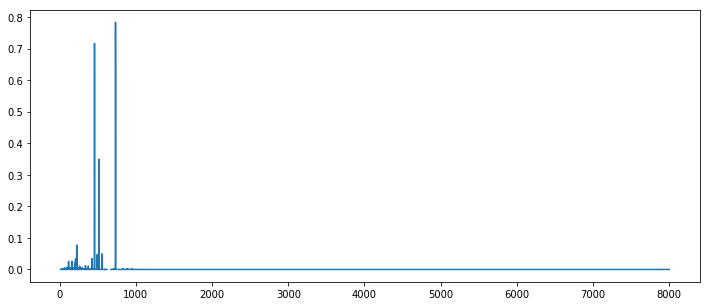

In [13]:
xs = np.linspace(10,8000,20000)
plt.plot(xs, divergence)
plt.show()